In [374]:
# !pip install pycaret pandas seaborn numpy scikit-learn --break-system-packages

In [375]:
import pandas as pd

Importa os dados

In [376]:
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')

Remove dados que não servem para o modelo e seleciona as features importantes

In [377]:
columns_to_drop = [
  'track_id', 'artists', 'album_name', 'track_name', 'track_unique_id'];

In [378]:
train = train.drop(columns=columns_to_drop)
test_droped = test.drop(columns=columns_to_drop)

Verifica a quantidade de nulos

In [379]:
train.isna().sum()

duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
track_genre          0
popularity_target    0
dtype: int64

Verifica a existencia de duplicatas

In [380]:
train.duplicated().sum()

6071

Remove as duplicatas e valores nulos

In [381]:
train.dropna(inplace=True)
train.drop_duplicates(inplace=True)

In [382]:
train.describe()

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity_target
count,7.372900e+04,73729.000000,73729.000000,73729.000000,73729.000000,73729.000000,73729.000000,73729.000000,73729.000000,73729.000000,73729.000000,73729.000000,73729.000000,73729.000000
mean,2.300604e+05,0.564368,0.642057,5.295067,-8.339691,0.634879,0.085487,0.315631,0.166315,0.215854,0.468751,122.283364,3.902589,0.520799
std,1.063644e+05,0.173173,0.253209,3.558324,5.082573,0.481467,0.107938,0.333699,0.317469,0.193528,0.259180,29.841426,0.436264,0.499571
min,1.338600e+04,0.000000,0.000019,0.000000,-49.307000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.757140e+05,0.454000,0.468000,2.000000,-10.128000,0.000000,0.035900,0.015600,0.000000,0.098200,0.254000,99.771000,4.000000,0.000000
50%,2.147380e+05,0.577000,0.686000,5.000000,-7.097000,1.000000,0.048900,0.170000,0.000060,0.132000,0.455000,122.053000,4.000000,1.000000
75%,2.646400e+05,0.692000,0.857000,8.000000,-5.028000,1.000000,0.084500,0.601000,0.077800,0.278000,0.677000,140.081000,4.000000,1.000000
max,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,222.605000,5.000000,1.000000


Encoda as variáveis categóricas que serão utilizadas no modelo

In [383]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train['track_genre'] = label_encoder.fit_transform(train['track_genre'])
test['track_genre'] = label_encoder.transform(test['track_genre'])
test['track_genre'] = test['track_genre']

Analisando os dados sobre as músicas mais populares, formulei as seguintes hipóteses:

**1. Hipótese sobre a relação entre gênero musical e popularidade:**
<br>
**Hipótese:** Alguns gêneros músicais se provam mais populares quando comparados com o geral. Podemos dizer que para predizer com precisão sobre a popularidade de uma música, é muito importante que usemos como feature o gênero do mesmo.

<Axes: xlabel='track_genre'>

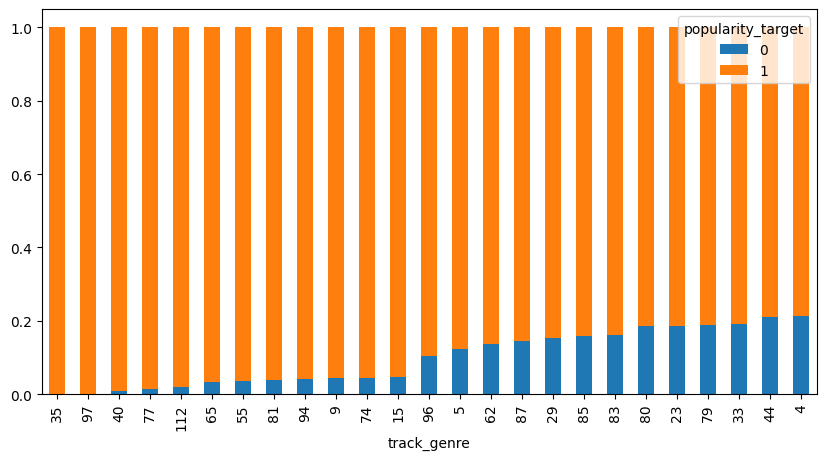

In [384]:
import seaborn as sns
import matplotlib.pyplot as plt

track_genre_popularity = train.groupby('track_genre')['popularity_target'].value_counts(normalize=True).unstack()
top_genre = track_genre_popularity.sort_values(by=1, ascending=False).head(25)
top_genre.plot(kind='bar', stacked='True', figsize=(10, 5))

<Axes: xlabel='track_genre'>

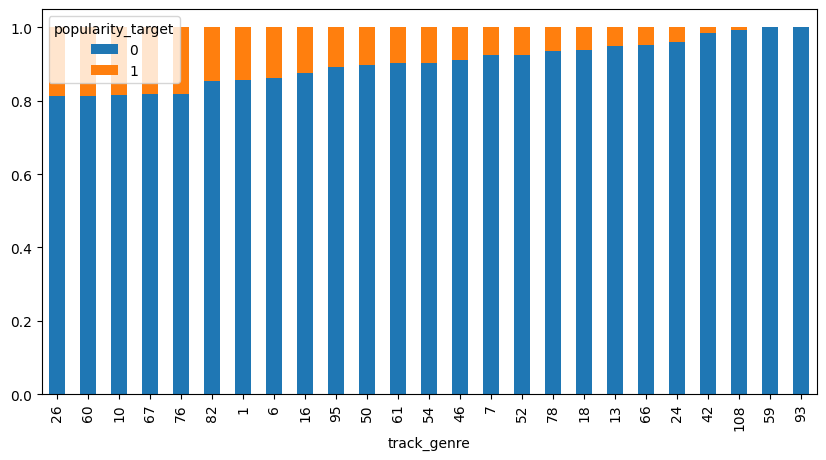

In [385]:
loss_genre = track_genre_popularity.sort_values(by=1, ascending=False).tail(25)
loss_genre.plot(kind='bar', stacked='True', figsize=(10, 5))

Se olharmos nos gráficos acima, podemos visualizar que alguns gêneros acumulam muito mais músicas populares do que outros. Isso nos mostra uma clara relação entre gênero músical e sua popularidade.

**2. Hipótese sobre o tempo da música e sua relação com a popularidade:**
<br>
**Hipótese:** Músicas com um BPM mais elevados costumam ter uma popularidade maior

/tmp/ipykernel_63628/2394540551.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train_hp2.groupby(['tempo_range', 'popularity_target']).size().unstack(fill_value=0)


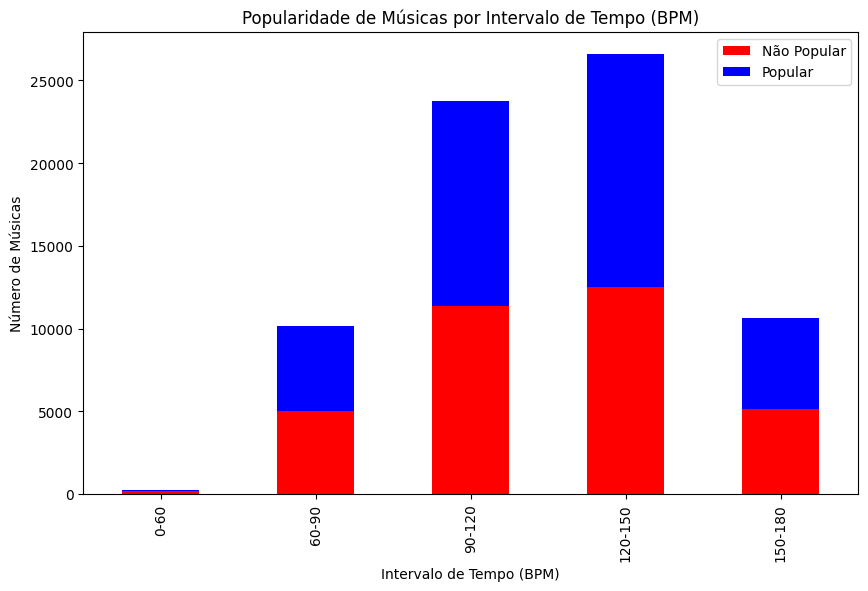

In [386]:
# Criar grupos de intervalo de tempo
bins = [0, 60, 90, 120, 150, 180]  # Definir intervalos de tempo (em BPM)
labels = ['0-60', '60-90', '90-120', '120-150', '150-180']
train_hp2 = pd.DataFrame()
train_hp2['tempo'] = train['tempo']
train_hp2['popularity_target'] = train['popularity_target']
train_hp2['tempo_range'] = pd.cut(train_hp2['tempo'], bins=bins, labels=labels)

# Contar popularidade em cada intervalo de tempo
grouped = train_hp2.groupby(['tempo_range', 'popularity_target']).size().unstack(fill_value=0)

# Criar gráfico de barras
grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'blue'])

# Personalizar gráfico
plt.title('Popularidade de Músicas por Intervalo de Tempo (BPM)')
plt.xlabel('Intervalo de Tempo (BPM)')
plt.ylabel('Número de Músicas')
plt.legend(['Não Popular', 'Popular'])
plt.show()

**3. Hipótese sobre a dançabilidade e popularidade**
<br>
**Hipótese:** Músicas com uma dançabilidade elevada tem mais probabilidade de se tornarem popular 

/tmp/ipykernel_63628/2191209780.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = train_hp2.groupby(['danceability_range', 'popularity_target']).size().unstack(fill_value=0)


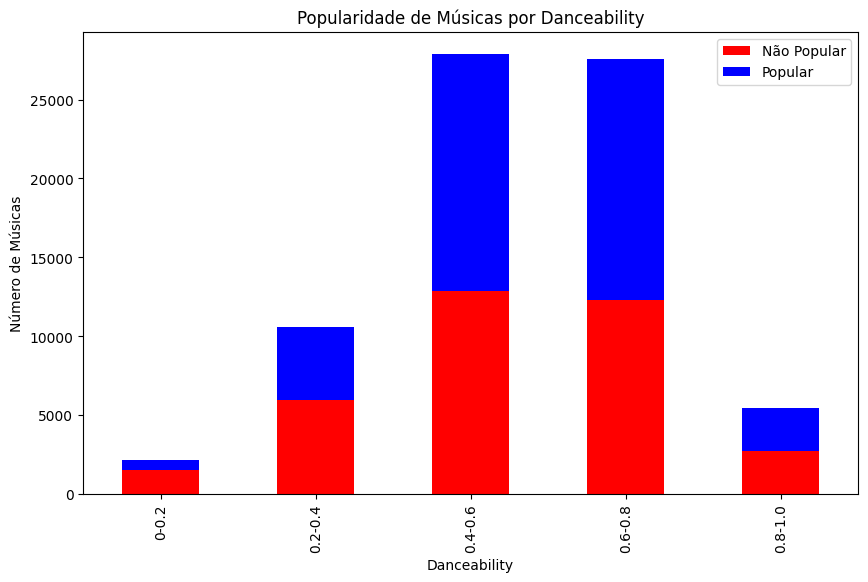

In [387]:
# Criar grupos de intervalo de danceability
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]  # Definir intervalos de danceability
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
train_hp2['danceability'] = train['danceability']
train_hp2['danceability_range'] = pd.cut(train_hp2['danceability'], bins=bins, labels=labels)

# Contar popularidade em cada intervalo de danceability
grouped = train_hp2.groupby(['danceability_range', 'popularity_target']).size().unstack(fill_value=0)

# Criar gráfico de barras
grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'blue'])

# Personalizar gráfico
plt.title('Popularidade de Músicas por Danceability')
plt.xlabel('Danceability')
plt.ylabel('Número de Músicas')
plt.legend(['Não Popular', 'Popular'])
plt.show()

Normalização de dados e seleção de features e target
Divisão de dados de treino e teste

In [388]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(train.drop(columns=['popularity_target']))
y = train['popularity_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Configuração do tunning do modelo

In [389]:
param_distributions = {
    'n_estimators': [100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

Estou utilizando o random forest como modelo de classificação, pois ele é um modelo robusto e que lida bem com dados desbalanceados

Treino do modelo e avaliação de best params do tunning

In [390]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

random_search = RandomizedSearchCV(
  estimator=rf_model,
  param_distributions=param_distributions,
  n_iter=10,
  cv=3,
  scoring='accuracy',
  verbose=2,
  random_state=42,
  n_jobs=-1
)

best = random_search.fit(X_train, y_train)

best.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  26.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  27.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  28.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; 

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

Verifica acuracia do modelo

In [391]:
from sklearn.metrics import accuracy_score
y_pred = random_search.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred))

Acurácia: 0.771008517333044


Verifica métricas além da acurácia do modelo

In [392]:
from sklearn.metrics import recall_score, roc_auc_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef

y_pred = random_search.predict(X_test)
y_prob = random_search.predict_proba(X_test)[:, 1]

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Kappa: {kappa:.4f}")
print(f"MCC: {mcc:.4f}")

Recall: 0.8083
Precision: 0.7656
F1-Score: 0.7864
AUC: 0.8498
Kappa: 0.5400
MCC: 0.5410


Gera os testes do modelo com os dados de teste passados pelo kaggle

In [393]:
test_droped['track_genre'] = label_encoder.transform(test_droped['track_genre'])

# captura as previsões
predictions['popularity_target'] = pd.DataFrame(random_search.predict(scaler.transform(test_droped)))
predictions['track_unique_id'] = test['track_unique_id']
predictions = predictions[['track_unique_id', 'popularity_target']]

predictions.to_csv('../assets/predictions.csv', index=False)

SyntaxError: invalid syntax (1428202575.py, line 4)